# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Final Project: 

## Anna's Notebook


**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader and Chris Tanner

<hr style="height:2pt">



In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics

import seaborn as sns

from pandas.plotting import scatter_matrix
# TODO remove before submitting
import warnings
warnings.simplefilter('ignore')


# Classification


In [2]:
#read in data
songs_df = pd.read_csv('data/songs_all_decade.csv')
songs_df['tophit'] = np.where(songs_df['Popularity'] > 60, 1, 0)
songs_df_clean = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID', 'Popularity'])

#songs_df_clean.head()

In [3]:
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(songs_df_clean.loc[:, songs_df_clean.columns != 'tophit'], 
                                                    songs_df_clean.tophit, train_size = 0.8, 
                                                    random_state = 100, stratify = songs_df_clean.tophit)

---

In [4]:
#standardize data
cat_cols = ['Key', 'Time Signature']
X_train_num = X_train.drop(cat_cols, axis = 1)
X_test_num = X_test.drop(cat_cols, axis = 1)
num_features = X_train_num.columns.tolist()
num_index_train = X_train.index.tolist()
num_index_test = X_test.index.tolist()

X_train_dum = pd.get_dummies(X_train[cat_cols], columns = cat_cols)
X_test_dum = pd.get_dummies(X_test[cat_cols], columns = cat_cols)

scaler = MinMaxScaler().fit(X_train_num)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), index = num_index_train, columns = num_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), index = num_index_test, columns = num_features)

X_train = pd.concat([X_train_dum, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_dum, X_test_scaled], axis = 1)

In [5]:
#X_train.head()
#X_test.head()

### Simple OLS

In [6]:
#simple linear regression classification
OLSmodel = LinearRegression().fit(X_train, y_train.values)

y_hat_train = OLSmodel.predict(X_train)
y_hat_test = OLSmodel.predict(X_test).astype(int)

train_score = accuracy_score(y_train, np.round(y_hat_train))*100
test_score = accuracy_score(y_test, np.round(y_hat_test))*100

print("Train accuracy:", train_score)
print("Test accuracy:", test_score)

Train accuracy: 82.69541253757934
Test accuracy: 82.7135062910589


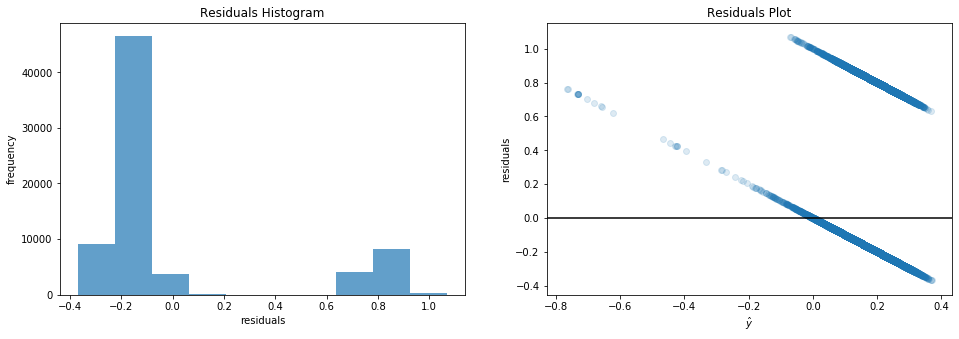

In [7]:
#residual plots
residuals = y_train - y_hat_train

fig, ax = plt.subplots(1,2, figsize=(16,5))
ax = ax.ravel()

ax[0].hist(residuals, alpha=0.7)
ax[0].set_title('Residuals Histogram')
ax[0].set_xlabel('residuals')
ax[0].set_ylabel('frequency')

ax[1].set_title('Residuals Plot')
ax[1].scatter(y_hat_train, residuals, alpha=0.15)
ax[1].set_xlabel(r'$\hat{y}$')
ax[1].set_ylabel('residuals')
ax[1].axhline(0, color='k');

### Add interaction terms

In [8]:
# #try using interaction terms but get error

# keys = X_train.columns[X_train.columns.str.startswith('Key')]
# time_sigs = X_train.columns[X_train.columns.str.startswith('Time')]

# def interactions(dframe, dummies=[keys, time_sigs], conts = ['Acousticness', 'Danceability', 'Duration_ms', 'Energy',
#                                                                        'Instrumentalness', 'Liveness', 'Loudness', 'Mode',
#                                                                        'Speechiness', 'Tempo', 'Valence']): 
#     df = dframe.copy()
#     for cont in conts:
#         for dummy in dummies:
#             df['{}*{}'.format(cont, dummy)] = dframe[cont]*dframe[dummy]
#     return df

# #train polynomial model with interactions
# x_int_train = interactions(X_train)
# x_int_test = interactions(X_test)

### Add polynomial terms

In [9]:
#polynomial regression
def higher_order(dframe, degree, cols = ['Acousticness', 'Danceability', 'Duration_ms', 'Energy',
                                           'Instrumentalness', 'Liveness', 'Loudness', 'Mode',
                                           'Speechiness', 'Tempo', 'Valence']): 
    for col in cols:
        for i in range(2, degree+1):
            dframe['{}^{}'.format(col, i)] = dframe[col]**i
    return dframe

x_poly_train = higher_order(X_train, 10)
x_poly_test = higher_order(X_test, 10)

#train model
model = LinearRegression()
model.fit(x_poly_train, y_train)

y_poly_pred_train = model.predict(x_poly_train)
y_poly_pred_test = model.predict(x_poly_test)

train_score = accuracy_score(y_train, np.round(y_poly_pred_train))*100
test_score = accuracy_score(y_test, np.round(y_poly_pred_test))*100

print("Train accuracy:", train_score)
print("Test accuracy:", test_score)

Train accuracy: 82.71072263667743
Test accuracy: 82.69680436477007


### Ridge Model

In [10]:
alphas = [.1,.5,1,5,10,50,100, 1000, 100000]

#ridge model
ridge_model = RidgeCV(alphas=alphas).fit(X_train, y_train)
best_ridge = ridge_model.alpha_
print(f'Best regularization level for ridge regression: {best_ridge}')
y_ridge_pred_train = ridge_model.predict(X_train)
y_ridge_pred_test = ridge_model.predict(X_test)

train_score = accuracy_score(y_train, np.round(y_ridge_pred_train))*100
test_score = accuracy_score(y_test, np.round(y_ridge_pred_test))*100

print("Train accuracy:", train_score)
print("Test accuracy:", test_score)
print('number of predictors:', len(ridge_model.coef_))


#ridge model for polynomials
ridge_model = RidgeCV(alphas=alphas).fit(x_poly_train, y_train)
best_ridge = ridge_model.alpha_
print(f'Best regularization level for ridge regression: {best_ridge}')
y_ridge_pred_train_poly = ridge_model.predict(x_poly_train)
y_ridge_pred_test_poly = ridge_model.predict(x_poly_test)

train_score = accuracy_score(y_train, np.round(y_ridge_pred_train_poly))*100
test_score = accuracy_score(y_test, np.round(y_ridge_pred_test_poly))*100

print("Train accuracy:", train_score)
print("Test accuracy:", test_score)
print('number of predictors:', len(ridge_model.coef_))


Best regularization level for ridge regression: 0.1
Train accuracy: 82.71211446386818
Test accuracy: 82.7135062910589
number of predictors: 127
Best regularization level for ridge regression: 0.1
Train accuracy: 82.71211446386818
Test accuracy: 82.7135062910589
number of predictors: 127


### Lasso Model

In [11]:
#lasso model
lasso_model = LassoCV(alphas=alphas, max_iter=100000).fit(X_train, y_train)
best_lasso = lasso_model.alpha_
print(f'Best regularization level for lasso regression: {best_lasso}')
y_lasso_pred_train = lasso_model.predict(X_train)
y_lasso_pred_test = lasso_model.predict(X_test)

train_score = accuracy_score(y_train, np.round(y_lasso_pred_train))*100
test_score = accuracy_score(y_test, np.round(y_lasso_pred_test))*100

print("Train accuracy:", train_score)
print("Test accuracy:", test_score)
print('number of predictors:', len(lasso_model.coef_))

#lasso for polynomial terms
lasso_model1 = LassoCV(alphas=alphas, max_iter=100000).fit(x_poly_train, y_train)
best_lasso1 = lasso_model1.alpha_
print(f'Best regularization level for lasso regression: {best_lasso1}')
y_lasso_pred_train_poly = lasso_model1.predict(x_poly_train)
y_lasso_pred_test_poly = lasso_model1.predict(x_poly_test)

train_score = accuracy_score(y_train, np.round(y_lasso_pred_train_poly))*100
test_score = accuracy_score(y_test, np.round(y_lasso_pred_test_poly))*100

print("Train accuracy:", train_score)
print("Test accuracy:", test_score)
print('number of predictors:',len(lasso_model1.coef_))

Best regularization level for lasso regression: 100000.0
Train accuracy: 82.7135062910589
Test accuracy: 82.7135062910589
number of predictors: 127
Best regularization level for lasso regression: 100000.0
Train accuracy: 82.7135062910589
Test accuracy: 82.7135062910589
number of predictors: 127


### Plot Coefficients

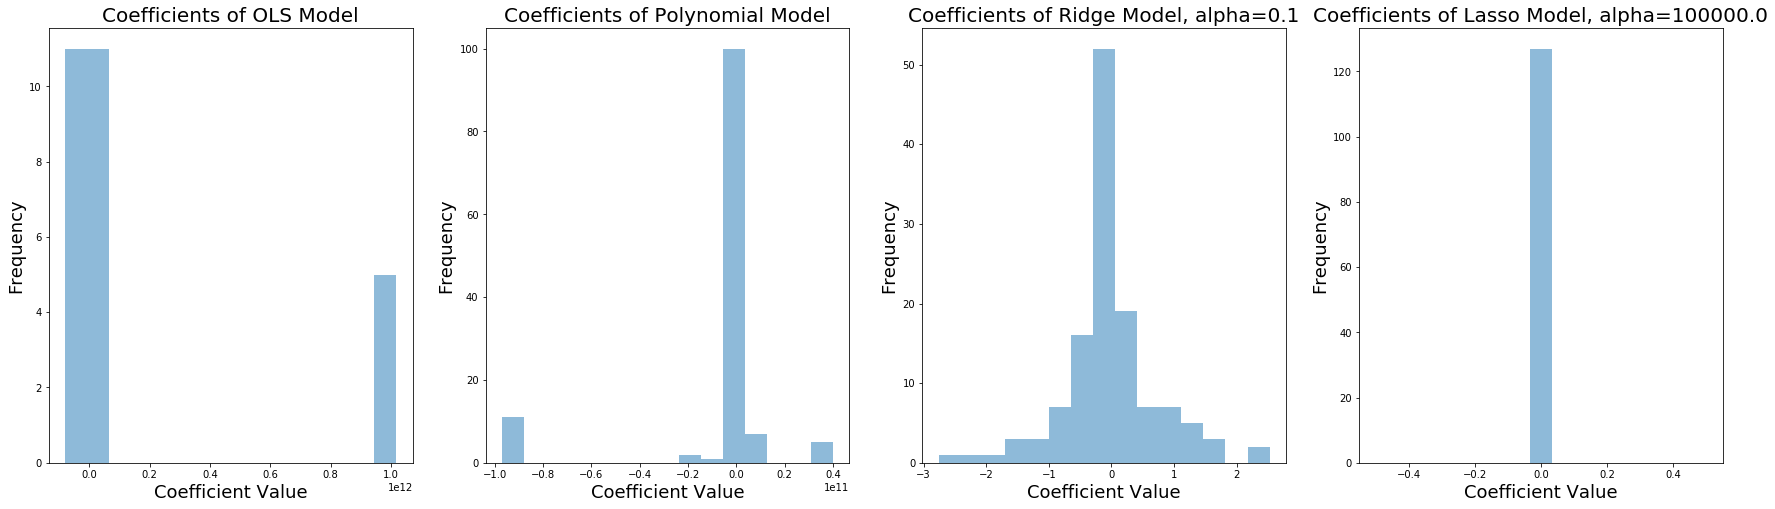

In [12]:
fig, ax = plt.subplots(figsize=(30,8), ncols=4)
ax = ax.ravel()

ax[0].hist(OLSmodel.coef_[1:], bins=15, alpha=0.5)
ax[0].set_title('Coefficients of OLS Model', fontsize=20)
ax[0].set_xlabel('Coefficient Value', fontsize=18)
ax[0].set_ylabel('Frequency', fontsize=18)

ax[1].hist(model.coef_[1:], bins=15, alpha=0.5)
ax[1].set_title('Coefficients of Polynomial Model', fontsize=20)
ax[1].set_xlabel('Coefficient Value', fontsize=18)
ax[1].set_ylabel('Frequency', fontsize=18)

ax[2].hist(ridge_model.coef_.flatten(), bins=15, alpha=0.5)
ax[2].set_title(f'Coefficients of Ridge Model, alpha={best_ridge}', fontsize=20)
ax[2].set_xlabel('Coefficient Value', fontsize=18)
ax[2].set_ylabel('Frequency', fontsize=18)

ax[3].hist(lasso_model.coef_.flatten(), bins=15, alpha=0.5)
ax[3].set_title(f'Coefficients of Lasso Model, alpha={best_lasso}', fontsize=20)
ax[3].set_xlabel('Coefficient Value', fontsize=18)
ax[3].set_ylabel('Frequency', fontsize=18);

fig.savefig('coefhist.png')

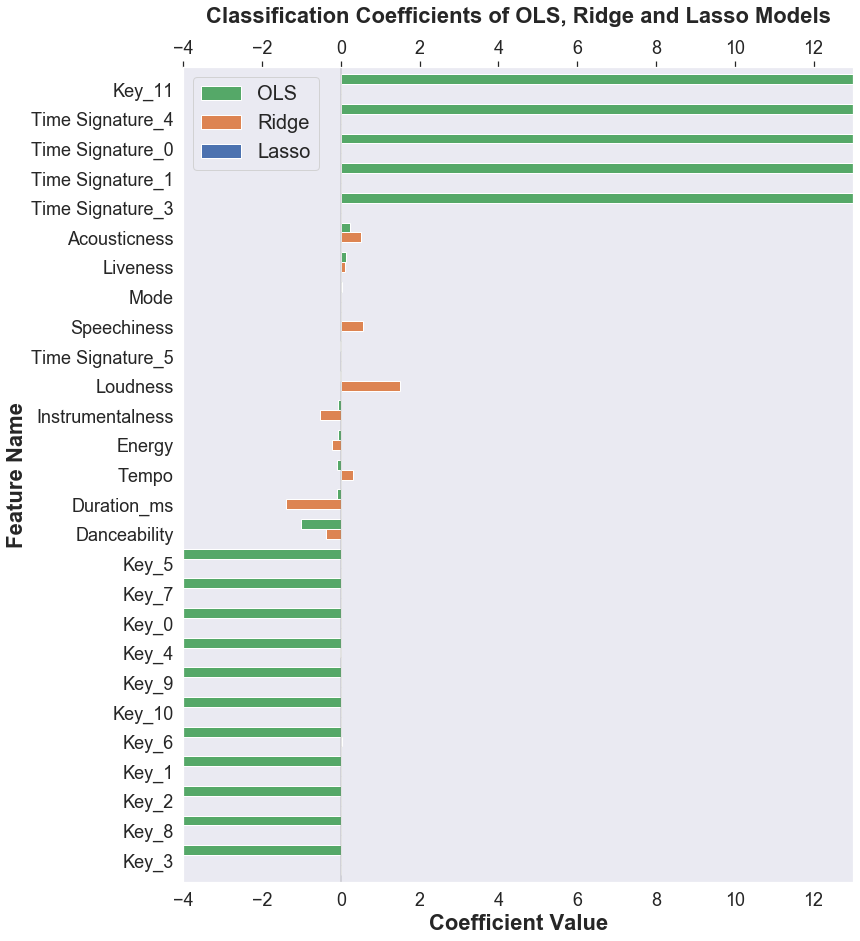

In [13]:
# outside sources: https://stackoverflow.com/questions/15201386/how-to-plot-multiple-horizontal-bars-in-one-chart-with-matplotlib
# also: https://stackoverflow.com/questions/6618515/sorting-list-based-on-values-from-another-list

OLS_vals = OLSmodel.coef_[1:]
order = OLS_vals.argsort()
OLS_vals = OLS_vals[order]

lasso_vals = lasso_model.coef_.flatten()[order]
ridge_vals = ridge_model.coef_.flatten()[order]

features = X_train.columns[order]

sns.set(style='dark', context='notebook')
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

df = pd.DataFrame({'Lasso': lasso_vals, 'Ridge': ridge_vals, 'OLS': OLS_vals}, index=features)
ax = df.plot.barh(figsize=(12,15), width=1)

# outside source: https://mode.com/example-gallery/python_horizontal_bar/
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, alpha=0.3, color='gray')

ax.set_xlabel('Coefficient Value', fontsize=22, fontweight='bold')
ax.set_ylabel('Feature Name', fontsize=22, fontweight='bold')
ax.set_xlim(-4, 13)

# outside source: https://matplotlib.org/1.3.1/users/legend_guide.html
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=20)

ax.tick_params(labelsize=18)
ax.set_title('Classification Coefficients of OLS, Ridge and Lasso Models', fontsize=22, pad=44, fontweight='bold');

fig = ax.get_figure()
fig.savefig("coef.png") 

---

## Regression




In [14]:
#read in data
songs_df = pd.read_csv('data/songs_all_decade.csv')
songs_df_clean2 = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID'])

#songs_df_clean2.head()

In [15]:
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(songs_df_clean2.loc[:, songs_df_clean2.columns != 'Popularity'], 
                                                    songs_df_clean2.Popularity, train_size = 0.8, 
                                                    random_state = 100)

In [16]:
#standardize data
cat_cols = ['Key', 'Time Signature']
X_train_num = X_train.drop(cat_cols, axis = 1)
X_test_num = X_test.drop(cat_cols, axis = 1)
num_features = X_train_num.columns.tolist()
num_index_train = X_train.index.tolist()
num_index_test = X_test.index.tolist()

X_train_dum = pd.get_dummies(X_train[cat_cols], columns = cat_cols)
X_test_dum = pd.get_dummies(X_test[cat_cols], columns = cat_cols)

scaler = MinMaxScaler().fit(X_train_num)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), index = num_index_train, columns = num_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), index = num_index_test, columns = num_features)

X_train = pd.concat([X_train_dum, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_dum, X_test_scaled], axis = 1)

In [17]:
#X_train.head()
#X_test.head()

### Simple OLS

In [18]:
#simple linear regression
OLSmodel = LinearRegression().fit(X_train, y_train)

y_hat_train = OLSmodel.predict(X_train)
y_hat_test = OLSmodel.predict(X_test)

print('Train R^2 = {:.4}'.format(r2_score(y_train, y_hat_train)))
print('Test R^2 = {:.4}'.format(r2_score(y_test, y_hat_test)))

Train R^2 = 0.09539
Test R^2 = 0.09839


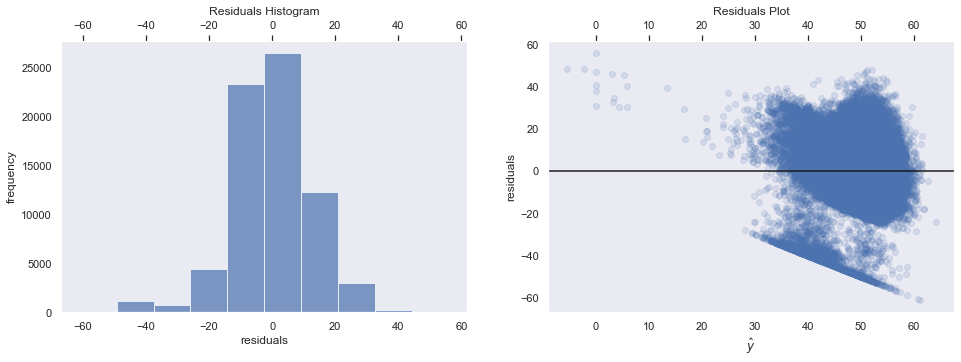

In [19]:
#residual plots
residuals = y_train - y_hat_train

fig, ax = plt.subplots(1,2, figsize=(16,5))
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
ax = ax.ravel()

ax[0].hist(residuals, alpha=0.7)
ax[0].set_title('Residuals Histogram')
ax[0].set_xlabel('residuals')
ax[0].set_ylabel('frequency')

ax[1].set_title('Residuals Plot')
ax[1].scatter(y_hat_train, residuals, alpha=0.15)
ax[1].set_xlabel(r'$\hat{y}$')
ax[1].set_ylabel('residuals')
ax[1].axhline(0, color='k');

fig.savefig('residual_plots.png')

### Add interaction terms

In [20]:
# #try using interaction terms but get error

# keys = X_train.columns[X_train.columns.str.startswith('Key')]
# time_sigs = X_train.columns[X_train.columns.str.startswith('Time')]

# def interactions(dframe, dummies=[keys, time_sigs], conts = ['Acousticness', 'Danceability', 'Duration_ms', 'Energy',
#                                                                        'Instrumentalness', 'Liveness', 'Loudness', 'Mode',
#                                                                        'Speechiness', 'Tempo', 'Valence']): 
#     df = dframe.copy()
#     for cont in conts:
#         for dummy in dummies:
#             df['{}*{}'.format(cont, dummy)] = dframe[cont]*dframe[dummy]
#     return df

# #train polynomial model with interactions
# x_int_train = interactions(X_train)
# x_int_test = interactions(X_test)

### Add polynomial terms

In [21]:
#polynomial regression
def higher_order(dframe, degree, cols = ['Acousticness', 'Danceability', 'Duration_ms', 'Energy',
                                           'Instrumentalness', 'Liveness', 'Loudness', 'Mode',
                                           'Speechiness', 'Tempo', 'Valence']): 
    df = dframe.copy()
    for col in cols:
        for i in range(2, degree+1):
            df['{}^{}'.format(col, i)] = dframe[col]**i
    return df

#train polynomial model
x_poly_train = higher_order(X_train, 2)
x_poly_test = higher_order(X_test, 2)

model = LinearRegression()
model.fit(x_poly_train, y_train)

y_poly_pred_train = model.predict(x_poly_train)
y_poly_pred_test = model.predict(x_poly_test)

print('Poly Train R^2 = {:.4}'.format(r2_score(y_train, y_poly_pred_train)))
print('Poly Test R^2 = {:.4}'.format(r2_score(y_test, y_poly_pred_test)))

Poly Train R^2 = 0.1236
Poly Test R^2 = 0.1275


### Ridge Model

In [22]:
#ridge model
alphas = [.1,.5,1,5,10,50,100, 1000, 100000]

ridge_model = RidgeCV(alphas=alphas).fit(X_train, y_train)
best_ridge = ridge_model.alpha_
print(f'Best regularization level for ridge regression: {best_ridge}')
y_ridge_pred_train = ridge_model.predict(X_train)
y_ridge_pred_test = ridge_model.predict(X_test)

print('Train R^2 = {:.4}'.format(r2_score(y_train, y_ridge_pred_train)))
print('Test R^2 = {:.4}'.format(r2_score(y_test, y_ridge_pred_test)))

ridge_model1 = RidgeCV(alphas=alphas).fit(x_poly_train, y_train)
best_ridge = ridge_model1.alpha_
print(f'Best regularization level for ridge regression: {best_ridge}')
y_ridge_pred_train_poly = ridge_model1.predict(x_poly_train)
y_ridge_pred_test_poly = ridge_model1.predict(x_poly_test)

print('Poly Train R^2 = {:.4}'.format(r2_score(y_train, y_ridge_pred_train_poly)))
print('Poly Test R^2 = {:.4}'.format(r2_score(y_test, y_ridge_pred_test_poly)))

Best regularization level for ridge regression: 0.5
Train R^2 = 0.09542
Test R^2 = 0.09822
Best regularization level for ridge regression: 0.1
Poly Train R^2 = 0.1237
Poly Test R^2 = 0.1274


### Lasso Model

In [23]:
#lasso model
lasso_model = LassoCV(alphas=alphas, max_iter=100000).fit(X_train, y_train)
best_lasso = lasso_model.alpha_
print(f'Best regularization level for lasso regression: {best_lasso}')
y_lasso_pred_train = lasso_model.predict(X_train)
y_lasso_pred_test = lasso_model.predict(X_test)

print('Train R^2 = {:.4}'.format(r2_score(y_train, y_lasso_pred_train)))
print('Test R^2 = {:.4}'.format(r2_score(y_test, y_lasso_pred_test)))
print('number of predictors:', len(lasso_model.coef_))



lasso_model1 = LassoCV(alphas=alphas, max_iter=100000).fit(x_poly_train, y_train)
best_lasso = lasso_model1.alpha_
print(f'Best regularization level for lasso regression: {best_lasso}')
y_lasso_pred_train_poly = lasso_model1.predict(x_poly_train)
y_lasso_pred_test_poly = lasso_model1.predict(x_poly_test)

print('Poly Train R^2 = {:.4}'.format(r2_score(y_train, y_ridge_pred_train_poly)))
print('Poly Test R^2 = {:.4}'.format(r2_score(y_test, y_ridge_pred_test_poly)))
print('number of predictors:', len(lasso_model1.coef_))


Best regularization level for lasso regression: 0.1
Train R^2 = 0.06786
Test R^2 = 0.07
number of predictors: 28
Best regularization level for lasso regression: 0.1
Poly Train R^2 = 0.1237
Poly Test R^2 = 0.1274
number of predictors: 39


### Plot Coefficients

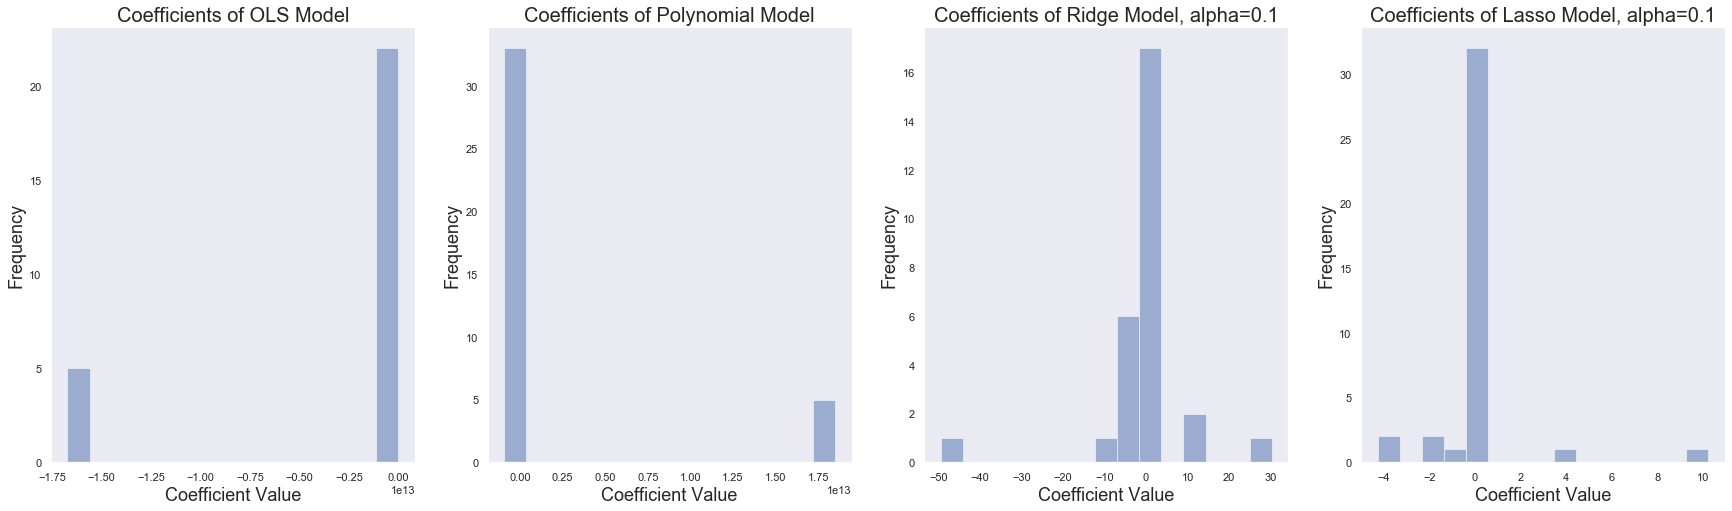

In [24]:
fig, ax = plt.subplots(figsize=(30,8), ncols=4)
ax = ax.ravel()

ax[0].hist(OLSmodel.coef_[1:], bins=15, alpha=0.5)
ax[0].set_title('Coefficients of OLS Model', fontsize=20)
ax[0].set_xlabel('Coefficient Value', fontsize=18)
ax[0].set_ylabel('Frequency', fontsize=18)

ax[1].hist(model.coef_[1:], bins=15, alpha=0.5)
ax[1].set_title('Coefficients of Polynomial Model', fontsize=20)
ax[1].set_xlabel('Coefficient Value', fontsize=18)
ax[1].set_ylabel('Frequency', fontsize=18)

ax[2].hist(ridge_model.coef_.flatten(), bins=15, alpha=0.5)
ax[2].set_title(f'Coefficients of Ridge Model, alpha={best_ridge}', fontsize=20)
ax[2].set_xlabel('Coefficient Value', fontsize=18)
ax[2].set_ylabel('Frequency', fontsize=18)

ax[3].hist(lasso_model1.coef_.flatten(), bins=15, alpha=0.5)
ax[3].set_title(f'Coefficients of Lasso Model, alpha={best_lasso}', fontsize=20)
ax[3].set_xlabel('Coefficient Value', fontsize=18)
ax[3].set_ylabel('Frequency', fontsize=18);

fig.savefig('coefhist2.png')

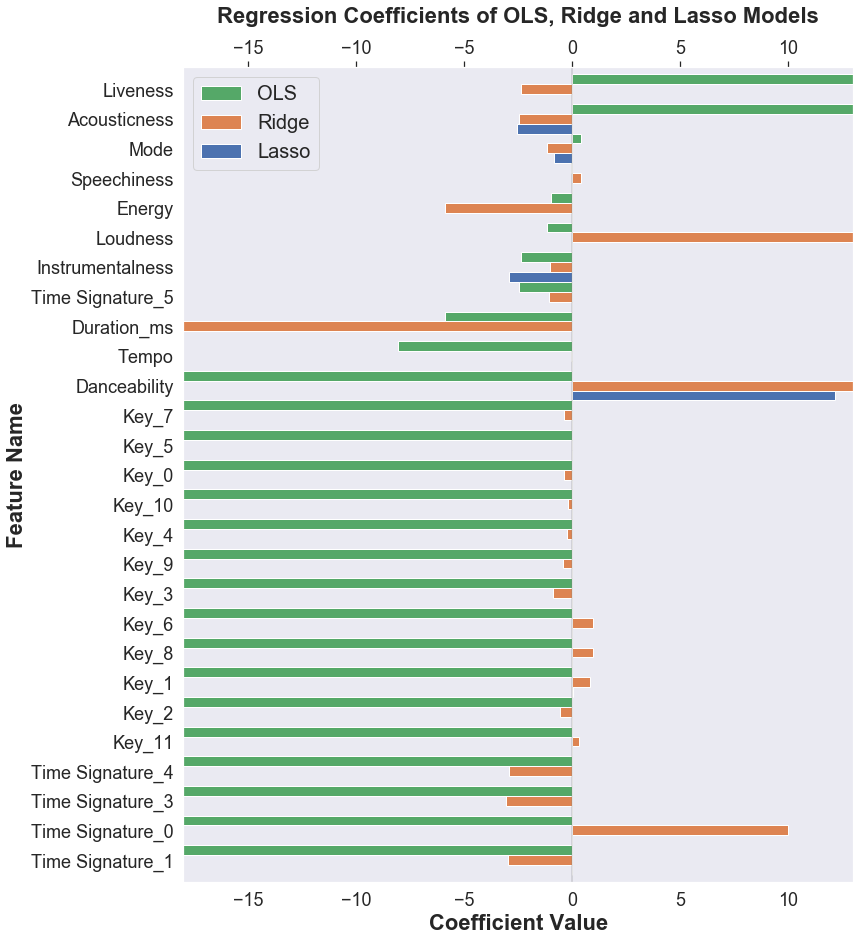

In [25]:
# outside sources: https://stackoverflow.com/questions/15201386/how-to-plot-multiple-horizontal-bars-in-one-chart-with-matplotlib
# also: https://stackoverflow.com/questions/6618515/sorting-list-based-on-values-from-another-list

OLS_vals = OLSmodel.coef_[1:]
order = OLS_vals.argsort()
OLS_vals = OLS_vals[order]

lasso_vals = lasso_model.coef_.flatten()[order]
ridge_vals = ridge_model.coef_.flatten()[order]

features = X_train.columns[order]

sns.set(style='dark', context='notebook')
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

df = pd.DataFrame({'Lasso': lasso_vals, 'Ridge': ridge_vals, 'OLS': OLS_vals}, index=features)
ax = df.plot.barh(figsize=(12,15), width=1)

# outside source: https://mode.com/example-gallery/python_horizontal_bar/
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, alpha=0.3, color='gray')

ax.set_xlabel('Coefficient Value', fontsize=22, fontweight='bold')
ax.set_ylabel('Feature Name', fontsize=22, fontweight='bold')
ax.set_xlim(-18, 13)

# outside source: https://matplotlib.org/1.3.1/users/legend_guide.html
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=20)

ax.tick_params(labelsize=18)
ax.set_title('Regression Coefficients of OLS, Ridge and Lasso Models', fontsize=22, pad=44, fontweight='bold');

fig = ax.get_figure()
fig.savefig("coef2.png") 
